In [3]:
x

In [440]:
#base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import matplotlib.image as mpimg
%matplotlib inline
from timeit import default_timer as timer
from tensorflow import keras


#image manipulation packages
import cv2
import os
from tqdm import tqdm
from glob import glob
from sklearn.metrics import confusion_matrix,classification_report

#Classification
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
sns.set()

import glob
import cv2
import shutil
import random
import Augmentor

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import models
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling2D



## RESNET50

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50


### Efficient
from tensorflow.keras.applications import EfficientNetB7


from PIL import Image
import PIL

import re

In [159]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [448]:
def crearDataset(path_expertAnotations,path_partialImages, dest_path):
    file = open(path_expertAnotations, 'r')
    os.mkdir(dest_path+'/data')
    os.mkdir(dest_path+'/data/01-Normal')
    os.mkdir(dest_path+'/data/02-Tapered')
    os.mkdir(dest_path+'/data/03-Pyriform')
    os.mkdir(dest_path+'/data/04-Small')
    os.mkdir(dest_path+'/data/05-Amorphous')

    categorias = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']

    for x in file:
        # Se obtiene el nombre y clase desde el archivo txt
        aux1 = x.split('	')
        clase = int(aux1[4].replace('\n',''))
        aux2 = aux1[0].replace('\n','').split('-')
        p = aux2[0]
        pl = aux2[1]
        aux3 = aux2[2].split('/')

        n_sample = int(re.split('(\d+)',aux3[0])[1])
        n_sperm = int(re.split('(\d+)',aux3[1])[1])
        # Se conforma el directorio de la imagen a partir de la informacion anterior.
        file = path_partialImages+'ch00_'+p+'-'+pl+'-sample'+str(n_sample)+'-sperm'+str(n_sperm)+'.tif'
        # Se conforma el directorio donde se va a copiar la imagen
        print(file)
        aux = dest_path+'/data/'
        if (clase == 0):
            aux=aux+'01-Normal'
        elif (clase == 1):
            aux=aux+'02-Tapered'
        elif (clase == 2):
            aux=aux+'03-Pyriform'
        elif (clase == 3):
            aux=aux+'04-Small'
        else:
            aux=aux+'05-Amorphous'

        # Se copia la imagen
        shutil.copy(file,aux)    


In [29]:
def fileCount(folder):
    "count the number of files in a directory"

    count = 0

    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)

        if os.path.isfile(path):
            count += 1
        elif os.path.isdir(path):
            count += fileCount(path)

    return count

In [450]:
crearDataset("/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/PA-expert-annotations.txt", '/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/',"/home/mcoronado/Escritorio/Codigo-Memoria/Data-set")


/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/ch00_p1-pl2-sample1-sperm1.tif
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/ch00_p1-pl2-sample1-sperm2.tif
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/ch00_p1-pl2-sample1-sperm3.tif
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/ch00_p1-pl2-sample1-sperm4.tif
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/ch00_p1-pl2-sample1-sperm5.tif
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/ch00_p1-pl2-sample1-sperm6.tif
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/ch00_p1-pl2-sample1-sperm10.tif
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/ch00_p1-pl2-sample1-sperm12.tif
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/ch00_p1-pl2-sample2-sperm3.tif
/home/mcoronado/Escritorio/Codigo-M

In [632]:
def crearSubConjuntos( nombre_clase, dir_clase, dest_dir):
    os.mkdir(dest_dir+"/train/"+nombre_clase)
    os.mkdir(dest_dir+"/test/"+nombre_clase)
    os.mkdir(dest_dir+"/valid/"+nombre_clase)
    
    lista = os.listdir(dir_clase)
    cantidad_imagenes = len(lista)
    contador = 0
    while (cantidad_imagenes*0.2) > contador:
        elemento = random.choice(lista)
        lista.remove(elemento)
        elemento = dir_clase+'/'+elemento
        shutil.copy(elemento,dest_dir+"/test/"+nombre_clase)
        contador = contador+1

    contador = 0
    while (cantidad_imagenes*0.2) > contador:
        elemento = random.choice(lista)
        lista.remove(elemento)
        elemento = dir_clase+'/'+elemento
        shutil.copy(elemento,dest_dir+"/valid/"+nombre_clase)
        contador = contador+1

    while len(lista) > 0:
        elemento = random.choice(lista)
        lista.remove(elemento)
        elemento = dir_clase+'/'+elemento
        shutil.copy(elemento,dest_dir+"/train/"+nombre_clase)
        contador = contador+1

def crearConjuntos( root_dir, dest_dir ):
    if os.path.exists(dest_dir+"/train"):
        shutil.rmtree(dest_dir+"/train")
    if os.path.exists(dest_dir+"/test"):
        shutil.rmtree(dest_dir+"/test")
    if os.path.exists(dest_dir+"/valid"):
        shutil.rmtree(dest_dir+"/valid")
    os.mkdir(dest_dir+"/train")
    os.mkdir(dest_dir+"/test")
    os.mkdir(dest_dir+"/valid")
    crearSubConjuntos( '01-Normal', root_dir+'/01-Normal', dest_dir )
    crearSubConjuntos( '02-Tapered', root_dir+'/02-Tapered', dest_dir )
    crearSubConjuntos( '03-Pyriform', root_dir+'/03-Pyriform', dest_dir )
    crearSubConjuntos( '04-Small', root_dir+'/04-Small', dest_dir )
    crearSubConjuntos( '05-Amorphous', root_dir+'/05-Amorphous', dest_dir )

In [ ]:
def copyImageFromList( root_dir, dest_dir, image_list ):
        element = random.choice(image_list)
        image_list.remove(element)
        element = root_dir+'/'+class_name+'/'+element
        shutil.copy(element,dest_dir+'/'+class_name)       

In [633]:
def generate_kFold_classImages( class_name, root_dir, list_paths, valid_path):
    images_in_folder = os.listdir(root_dir+'/'+class_name)
    len_images = len(images_in_folder)
    percentage_per_fold = (100/len(list_paths))/100

    for i in range(len(list_paths)):
        dest_dir = list_paths[i]
        if (i == 0):
            count = 0
            while (len_images*percentage_per_fold)*0.2 > count:
                element = random.choice(images_in_folder)
                images_in_folder.remove(element)
                element = root_dir+'/'+class_name+'/'+element
                shutil.copy(element,valid_path+'/'+class_name)  
                count = count+1 
            count = 0
            while (len_images*percentage_per_fold)*0.8 > count:
                element = random.choice(images_in_folder)
                images_in_folder.remove(element)
                element = root_dir+'/'+class_name+'/'+element
                shutil.copy(element,dest_dir+'/'+class_name)  
                count = count+1
                
        elif ( i ==  len(list_paths)-1):
            while len(images_in_folder) > 0:
                element = random.choice(images_in_folder)
                images_in_folder.remove(element)
                element = root_dir+'/'+class_name+'/'+element
                shutil.copy(element,dest_dir+'/'+class_name)                
        else:
            count = 0
            while (len_images*percentage_per_fold) > count:
                element = random.choice(images_in_folder)
                images_in_folder.remove(element)
                element = root_dir+'/'+class_name+'/'+element
                shutil.copy(element,dest_dir+"/"+class_name)
                count = count+1            
    

In [471]:
def generate_kFold_partitionImages( original_dir,dest_dir, k_folds ):
    percentage_per_fold = int(100/k_folds)
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)   
    os.mkdir(dest_dir)
    
    list_paths = []
    for i in range(0,k_folds+1):
        if (i == 0):
            ifold_fileName = 'valid'
        else:
            ifold_fileName = 'fold_'+str(i)
        ifold_path = dest_dir+ifold_fileName
        if os.path.exists(ifold_path):
            shutil.rmtree(ifold_path)
        os.mkdir(ifold_path)
        os.mkdir(ifold_path+'/01-Normal')
        os.mkdir(ifold_path+'/02-Tapered')
        os.mkdir(ifold_path+'/03-Pyriform')
        os.mkdir(ifold_path+'/04-Small')
        os.mkdir(ifold_path+'/05-Amorphous')
        if( i!= 0):
            list_paths.append(ifold_path)
    valid_path = dest_dir+'valid'
    generate_kFold_classImages( '01-Normal', original_dir, list_paths, valid_path)
    generate_kFold_classImages( '02-Tapered', original_dir, list_paths, valid_path)
    generate_kFold_classImages( '03-Pyriform', original_dir, list_paths, valid_path)
    generate_kFold_classImages( '04-Small', original_dir, list_paths, valid_path)
    generate_kFold_classImages( '05-Amorphous', original_dir, list_paths, valid_path)
    return list_paths
        


In [525]:
def eliminarImagenesAumentadas( image_dir ):
    class_names = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']
    for class_name in class_names:
        if os.path.exists(image_dir+'/'+class_name+'/output'):
            shutil.rmtree(image_dir+'/'+class_name+'/output')    

In [ ]:
def generate_kFold_validation( root_dir ):
    root_dir = root_dir+'valid'
    if os.path.exists(root_dir):
        shutil.rmtree(root_dir)   
    os.mkdir(root_dir)
    

In [526]:
def k_fold_dataAugmentation( kfold_paths , n_images_target):
    for i in range(len(kfold_paths)):
        if (i == 0):
            aumentarImagenesSCIAN( kfold_paths[i] ,int(n_images_target*0.80) )
        else:
            aumentarImagenesSCIAN( kfold_paths[i] ,n_images_target )
    

In [527]:
def k_fold_dataAugmentation_delete( kfold_paths ):
    for i in range(len(kfold_paths)):
        eliminarImagenesAumentadas( kfold_paths[i] )    

In [ ]:
def read_train_kfold( n_fold , root_dir):
    
    return data_gen

In [628]:
# Arreglo 
# 
def k_fold_moveTrainImages(n_kfold, kfold_paths, dest_dir):
    # [nombreImagen, path_fold, original/aumentada]
    all_images_objects = []
    classes_names = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']
    if os.path.exists(dest_dir+'/train'):
        shutil.rmtree(dest_dir+'/train')   
    os.mkdir(dest_dir+"/train")
    for class_name in classes_names:
        os.mkdir(dest_dir+"/train/"+class_name)
        os.mkdir(dest_dir+"/train/"+class_name+'/output')
    for i in range(0,len(kfold_paths)):
        if (i != n_kfold-1):
            path = kfold_paths[i]
            for class_name in classes_names:
                class_path = path+'/'+class_name
                image_names= os.listdir(class_path)
                for image in image_names:
                    if image.endswith(".tif"):
                        image_dir = class_path+'/'+image
                        all_images_objects.append([image, class_path, 'original'])
                        shutil.move( image_dir, dest_dir+'train/'+class_name)

                augmentated_image_names= os.listdir(class_path+'/output')
                for image in augmentated_image_names:
                    if image.endswith(".tif"):
                        image_dir = class_path+'/output/'+image
                        all_images_objects.append([image, class_path+'/output', 'augmented'])
                        shutil.move( image_dir, dest_dir+'train/'+class_name+'/output')
    return all_images_objects

In [553]:
def k_fold_returnTrainImages( n_kfold, kfold_paths):
    print('w')

In [629]:
#k_folds = 5
#list_kfold_paths = generate_kFold_partitionImages( original_dir='/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/data/', dest_dir='/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/', k_folds= k_folds)
#k_fold_dataAugmentation(list_kfold_paths,1600)
#k_fold_moveTrainImages(1,list_kfold_paths,'/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/')

In [562]:
def k_fold_returnTrainImages(n_kfold, kfold_paths, des_dir,all_dir_object):

SyntaxError: unexpected EOF while parsing (3892630249.py, line 1)

ValueError: If using `weights` as `"imagenet"` with `include_top` as true, `classes` should be 1000.  Received `classes=4`

In [162]:
def contarArchivos(folder):
    count = 0
    for root_dir, cur_dir, files in os.walk(folder):
        count += len(files)
    return count

In [523]:
k_fold_dataAugmentation_delete( list_kfold_paths ) 

In [163]:
# https://github.com/mdbloice/Augmentor/issues/125#issuecomment-410978015
from Augmentor.Operations import Operation
class TranslateImage(Operation):
    # Here you can accept as many custom parameters as required:
    def __init__(self, probability,max_left_translation,max_right_translation,max_down_translation,max_up_translation):
        # Call the superclass's constructor (meaning you must
        # supply a probability value):
        Operation.__init__(self, probability)
        # Set your custom operation's member variables here as required:
        self.max_left_translation = -abs(max_left_translation)
        self.max_right_translation = max_right_translation
        self.max_down_translation = -abs(max_down_translation)
        self.max_up_translation = max_up_translation

    # Your class must implement the perform_operation method:
    def perform_operation(self, images):
        # Start of code to perform custom image operation.
        def do(image):
            random_left = random.randint(self.max_left_translation, 0)
            random_right = random.randint(0, self.max_right_translation)
            left_or_right = random.randint(0, 1)
            translation_left_right = 0
            if left_or_right == 0:
                translation_left_right= random_left
            elif left_or_right == 1:
                translation_left_right = random_right
            
            random_down = random.randint(self.max_down_translation, 0)
            random_up = random.randint(0, self.max_up_translation)
            up_or_down = random.randint(0, 1)
            translation_up_down = 0
            if up_or_down == 0:
                translation_up_down = random_up
            elif up_or_down == 1:
                translation_up_down = random_down
            a = 1
            b = 0
            c = translation_left_right #left/right (i.e. 5/-5)
            d = 0
            e = 1
            f = translation_up_down  #up/down (i.e. 5/-5)
            #image = PIL.Image.fromarray(image)
            image = image.transform(image.size, PIL.Image.AFFINE, (a, b, c, d, e, f))
            return image
        
        augmented_images = []

        for image in images:
            augmented_images.append(do(image))

        return augmented_images

In [164]:
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)


In [630]:
## Diagnotics-10-00325
def aumentarImagenesSCIAN(data_path, cantidad_imagenes):
    #counts number of images in training data
    cantidad_train_1= contarArchivos(data_path+'01-Normal')
    cantidad_train_2 = contarArchivos(data_path+'02-Tapered')
    cantidad_train_3 = contarArchivos(data_path+'03-Pyriform')
    cantidad_train_4 = contarArchivos(data_path+'/04-Small')
    cantidad_train_5 = contarArchivos(data_path+'/05-Amorphous')

    ## Se instancia un Augmentor
    pipeline_normal = Augmentor.Pipeline(data_path+'/01-Normal')
    pipeline_tapered = Augmentor.Pipeline(data_path+'/02-Tapered')
    pipeline_pyriform = Augmentor.Pipeline(data_path+'/03-Pyriform')
    pipeline_small = Augmentor.Pipeline(data_path+'/04-Small')
    pipeline_morphous = Augmentor.Pipeline(data_path+'/05-Amorphous')

    ## Rotation -25° a 25°
    pipeline_normal.rotate_without_crop(probability=0.6, max_left_rotation=5, max_right_rotation=5)
    pipeline_tapered.rotate_without_crop(probability=0.6, max_left_rotation=5, max_right_rotation=5)
    pipeline_pyriform.rotate_without_crop(probability=0.5, max_left_rotation=5, max_right_rotation=5)
    pipeline_small.rotate_without_crop(probability=0.6, max_left_rotation=5, max_right_rotation=5)
    pipeline_morphous.rotate_without_crop(probability=0.4, max_left_rotation=5, max_right_rotation=5)

    ## Vertical flip
    pipeline_normal.flip_top_bottom(probability=0.6)
    pipeline_tapered.flip_top_bottom(probability=0.6)
    pipeline_pyriform.flip_top_bottom(probability=0.5)
    pipeline_small.flip_top_bottom(probability=0.6)
    pipeline_morphous.flip_top_bottom(probability=0.4)

    ## Trasladation (max 6% de la imagen = 3 pixeles )
    pipeline_normal.add_operation(TranslateImage(probability = 0.6, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))
    pipeline_tapered.add_operation(TranslateImage(probability = 0.6, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))
    pipeline_pyriform.add_operation(TranslateImage(probability = 0.5, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))
    pipeline_small.add_operation(TranslateImage(probability = 0.6, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))
    pipeline_morphous.add_operation(TranslateImage(probability = 0.4, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))

    # Se restan para asimilar la distribucion original de las imagenes.
    pipeline_normal.sample(cantidad_imagenes - cantidad_train_1)
    pipeline_tapered.sample(cantidad_imagenes - cantidad_train_2)
    pipeline_pyriform.sample(cantidad_imagenes - cantidad_train_3)
    pipeline_small.sample(cantidad_imagenes - cantidad_train_4)
    pipeline_morphous.sample(cantidad_imagenes - cantidad_train_5)
    
    
    

In [713]:
def crearDataGenerators(data_path):
    
    dataGen_train = ImageDataGenerator(rescale = 1./255,brightness_range=[0.2,1.5], fill_mode='nearest') 
    dataGen_valid = ImageDataGenerator(rescale = 1./255)
    dataGen_test = ImageDataGenerator(rescale = 1./255)

    #test different color maps -  class modes and cross validation types
    train = dataGen_train.flow_from_directory(data_path+'/train',
                                                     target_size = (35, 35),
                                                     batch_size = 1024,
                                                     shuffle = True,
                                                     class_mode="categorical")

    valid = dataGen_valid.flow_from_directory(data_path+'/valid',
                                                target_size = (35, 35),
                                                batch_size = 64,
                                                shuffle = True,
                                                class_mode="categorical")

    test = dataGen_test.flow_from_directory(data_path+'/test',
                                                target_size = (35, 35),
                                                batch_size = 1,
                                                shuffle = True,
                                                class_mode="categorical")
    return train,valid,test

In [722]:
def crearCNN_simple():
    #creating a model that will take inputs 32,32,1
    cnn_model = Sequential()

    #convolutional layer with 32 2x2 filters - output 14 x 14 active area
    cnn_model.add(Conv2D(filters=35, kernel_size=(4,4), padding = 'same', activation='relu')) 
    cnn_model.add(BatchNormalization())

    #2nd convolution with 64 filters  
    cnn_model.add(Conv2D(filters=64, kernel_size=(2,2), padding = 'same', activation= 'relu'))
    cnn_model.add(BatchNormalization())  

    #MaxPooling - takes the max value of each 2x2 pool in the feature map
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))
    cnn_model.add(BatchNormalization())

    #the result of kthe CNN is then flattened and placed into the 
    cnn_model.add(Flatten())
    cnn_model.add(Dense(576, activation='relu'))
    cnn_model.add(BatchNormalization())

    #widen layer
    cnn_model.add(Dense(1024, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))


    #shrink layer
    cnn_model.add(Dense(256, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))

    cnn_model.add(Dense(5))
    cnn_model.add(BatchNormalization())            
    cnn_model.add(Activation('softmax'))

    cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return cnn_model

In [492]:
def entrenarModelo(modelo, epochs, train_data, valid_data, callbacks):
    history = modelo.fit(train_data,
            epochs=epochs, 
            validation_data=valid_data,
            verbose = 1, 
            callbacks = callbacks) 
    return history

In [709]:
# https://keras.io/api/callbacks/
# Se utilizo como referencia el trabajo de Ricardo Santos.
def crearCallBacks(checkpoint_path):

    #https://keras.io/api/callbacks/model_checkpoint/
    model_checkPoint = ModelCheckpoint(filepath=checkpoint_path, verbose = 1, monitor='val_accuracy', mode='max', save_best_only=True)

    #https://keras.io/api/callbacks/early_stopping/
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights = True)

    #https://keras.io/api/callbacks/reduce_lr_on_plateau/
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0, verbose = 1)

    cb = TimingCallback()    
    return [model_checkPoint, es, reduce_lr, cb]

In [170]:
def imprimirMetricas(y_train, pred_train , y_val, pred_val):
    print( " Conjunto train "+"\n")
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train)+"\n")
    print( " Conjunto valid "+"\n")
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val)+"\n")

In [687]:
def evaluarModelo( modelo, test):
    test_loss, test_acc = modelo.evaluate(test)
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    #print("\nTime:",sum(modelo.callbacks.cb.logs)/60,"min")    
    
    prediction = modelo.predict( test )
    clase_predecida = np.argmax(prediction,axis=1)
    clase_verdadera = test.classes
    class_labels = list(test.class_indices.keys())   
    
    print(confusion_matrix(clase_verdadera, clase_predecida))
    print(classification_report(clase_verdadera, clase_predecida, target_names=class_labels))
    

In [714]:
#crearDataset("/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/PA-expert-annotations.txt", '/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/',"/home/mcoronado/Escritorio/Codigo-Memoria/Data-set")
#crearConjuntos('/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/data','/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/final_data')
#aumentarImagenesSCIAN('/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/final_data/train', 5000)
train,valid,test = crearDataGenerators('/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/final_data')

Found 25240 images belonging to 5 classes.
Found 229 images belonging to 5 classes.
Found 229 images belonging to 5 classes.


In [703]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model


def generateVGG16(input_shape, n_classes, fine_tune=0):
    base_model = VGG16(weights="imagenet", include_top=False, input_tensor=input_shape)
    if( fine_tune > 0):
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False    
    top_model = base_model.output
    top_model = Flatten(name='flatten')(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    final_model = Model(inputs=base_model.input, outputs=output_layer)
    final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return final_model
    #flatten_layer = layers.Flatten()
    #dense_layer_1 = layers.Dense(1024, activation='relu')
    #dense_layer_2 = layers.Dense(512, activation='relu')
    #prediction_layer = layers.Dense(5, activation='softmax')

    #final_mode = models.Sequential([
    #    base_model,
    #    flatten_layer,
    #    dense_layer_1,
    #    dense_layer_2,
    #    prediction_layer
    #])
    #final_mode.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    #              loss='categorical_crossentropy',
    #              metrics=['accuracy'])


In [679]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 34, 34, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 34, 34, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 34, 34, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 17, 17, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 17, 17, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 17, 17, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [715]:
vgg16_model = generateVGG16(Input(shape=(35, 35, 3)), 5, 2)

In [705]:
print(vgg16_model)

In [723]:
cnn7 = crearCNN_simple()

In [724]:
callbacks = crearCallBacks('/home/mcoronado/Escritorio/Models_AC')

In [725]:
model_history9 = entrenarModelo(cnn7, 50, train, valid, callbacks )

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.5437 - accuracy: 0.3274 
Epoch 1: val_accuracy improved from -inf to 0.31441, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 1289s 53s/step - loss: 1.5437 - accuracy: 0.3274 - val_loss: 1.5504 - val_accuracy: 0.3144 - lr: 0.0010
Epoch 2/50
11/25 [============>.................] - ETA: 4:35 - loss: 1.2955 - accuracy: 0.4589

KeyboardInterrupt: 

In [717]:
model_history8 = entrenarModelo(vgg16_model, 50, train, valid, callbacks )

Epoch 1/50


2022-11-01 01:16:09.196774: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 321126400 exceeds 10% of free system memory.


25/25 [==============================] - ETA: 0s - loss: 1.6831 - accuracy: 0.3411
Epoch 1: val_accuracy improved from -inf to 0.40175, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 85s 3s/step - loss: 1.6831 - accuracy: 0.3411 - val_loss: 1.2757 - val_accuracy: 0.4017 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.1846 - accuracy: 0.5014
Epoch 2: val_accuracy improved from 0.40175 to 0.43231, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 82s 3s/step - loss: 1.1846 - accuracy: 0.5014 - val_loss: 1.1889 - val_accuracy: 0.4323 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.0422 - accuracy: 0.5749
Epoch 3: val_accuracy did not improve from 0.43231
25/25 [==============================] - 79s 3s/step - loss: 1.0422 - accuracy: 0.5749 - val_loss: 1.2070 - val_accuracy: 0.4236 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.9451 - accuracy: 0.6212
Epoch 4: val_accuracy improved from 0.43231 to 0.48035, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 83s 3s/step - loss: 0.9451 - accuracy: 0.6212 - val_loss: 1.2078 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.9061 - accuracy: 0.6370
Epoch 5: val_accuracy improved from 0.48035 to 0.48908, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 86s 3s/step - loss: 0.9061 - accuracy: 0.6370 - val_loss: 1.0865 - val_accuracy: 0.4891 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 0.8476 - accuracy: 0.6589
Epoch 6: val_accuracy improved from 0.48908 to 0.53712, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 85s 3s/step - loss: 0.8476 - accuracy: 0.6589 - val_loss: 1.0341 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.7921 - accuracy: 0.6858
Epoch 7: val_accuracy improved from 0.53712 to 0.56769, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 83s 3s/step - loss: 0.7921 - accuracy: 0.6858 - val_loss: 1.0561 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.7196 - accuracy: 0.7182
Epoch 8: val_accuracy did not improve from 0.56769
25/25 [==============================] - 81s 3s/step - loss: 0.7196 - accuracy: 0.7182 - val_loss: 1.2072 - val_accuracy: 0.4847 - lr: 0.0010
Epoch 9/50
25/25 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.7244
Epoch 9: val_accuracy improved from 0.56769 to 0.58952, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 84s 3s/step - loss: 0.7035 - accuracy: 0.7244 - val_loss: 1.0641 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.7468
Epoch 10: val_accuracy did not improve from 0.58952
25/25 [==============================] - 80s 3s/step - loss: 0.6391 - accuracy: 0.7468 - val_loss: 1.1279 - val_accuracy: 0.5852 - lr: 0.0010
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.7433
Epoch 11: val_accuracy did not improve from 0.58952

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 [==============================] - 79s 3s/step - loss: 0.6512 - accuracy: 0.7433 - val_loss: 1.0920 - val_accuracy: 0.5590 - lr: 0.0010
Epoch 12/50
25/25 [==============================] - ETA: 0s - loss: 0.5701 - accuracy: 0.7784
Epoch 12: val_accuracy improved from 0.58952 to 0.60699, saving model to /home/mcoronado/Escritorio/Models_

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 83s 3s/step - loss: 0.5701 - accuracy: 0.7784 - val_loss: 1.2156 - val_accuracy: 0.6070 - lr: 5.0000e-04
Epoch 13/50
25/25 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.8010
Epoch 13: val_accuracy did not improve from 0.60699
25/25 [==============================] - 79s 3s/step - loss: 0.5155 - accuracy: 0.8010 - val_loss: 1.2271 - val_accuracy: 0.5852 - lr: 5.0000e-04
Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.8116
Epoch 14: val_accuracy did not improve from 0.60699
25/25 [==============================] - 79s 3s/step - loss: 0.4853 - accuracy: 0.8116 - val_loss: 1.2798 - val_accuracy: 0.5983 - lr: 5.0000e-04
Epoch 15/50
25/25 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8225
Epoch 15: val_accuracy did not improve from 0.60699
25/25 [==============================] - 81s 3s/step - loss: 0.4680 - accuracy: 0.8225 - val_loss: 1.3051 - val_accuracy:

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 83s 3s/step - loss: 0.3909 - accuracy: 0.8540 - val_loss: 1.4437 - val_accuracy: 0.6114 - lr: 2.5000e-04
Epoch 20/50
25/25 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.8571
Epoch 20: val_accuracy improved from 0.61135 to 0.62009, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 85s 3s/step - loss: 0.3839 - accuracy: 0.8571 - val_loss: 1.4536 - val_accuracy: 0.6201 - lr: 2.5000e-04
Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8568
Epoch 21: val_accuracy did not improve from 0.62009

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
25/25 [==============================] - 79s 3s/step - loss: 0.3831 - accuracy: 0.8568 - val_loss: 1.4575 - val_accuracy: 0.6201 - lr: 2.5000e-04
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8635
Epoch 22: val_accuracy did not improve from 0.62009
25/25 [==============================] - 79s 3s/step - loss: 0.3642 - accuracy: 0.8635 - val_loss: 1.4723 - val_accuracy: 0.5983 - lr: 1.2500e-04
Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8680
Epoch 23: val_accuracy did not improve from 0.62009
25/25 [==============================] - 80

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 84s 3s/step - loss: 0.3463 - accuracy: 0.8720 - val_loss: 1.5184 - val_accuracy: 0.6245 - lr: 1.2500e-04
Epoch 26/50
25/25 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8721
Epoch 26: val_accuracy improved from 0.62445 to 0.62882, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


Restoring model weights from the end of the best epoch: 6.

Epoch 26: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
25/25 [==============================] - 86s 3s/step - loss: 0.3401 - accuracy: 0.8721 - val_loss: 1.5491 - val_accuracy: 0.6288 - lr: 1.2500e-04
Epoch 26: early stopping


In [56]:
evaluarModelo(cnn, test)

105/105 [==============================] - 1s 6ms/step - loss: 0.8831 - accuracy: 0.6381
Test loss: 0.8830553293228149
Test accuracy: 0.6380952596664429
105/105 [==============================] - 1s 6ms/step
[[ 1  4  0  1  4]
 [ 4  2  1  3 11]
 [ 1  3  0  1  2]
 [ 1  1  0  1  4]
 [12 10  2  4 32]]
              precision    recall  f1-score   support

   01-Normal       0.05      0.10      0.07        10
  02-Tapered       0.10      0.10      0.10        21
 03-Pyriform       0.00      0.00      0.00         7
    04-Small       0.10      0.14      0.12         7
05-Amorphous       0.60      0.53      0.57        60

    accuracy                           0.34       105
   macro avg       0.17      0.17      0.17       105
weighted avg       0.38      0.34      0.36       105



In [180]:
evaluarModelo(cnn1, test)

105/105 [==============================] - 1s 6ms/step - loss: 1.5987 - accuracy: 0.2000
Test loss: 1.5987111330032349
Test accuracy: 0.20000000298023224
105/105 [==============================] - 1s 6ms/step
[[ 0  2  0  2  6]
 [ 2  2  1  1 15]
 [ 2  1  0  1  3]
 [ 1  0  1  0  5]
 [ 7  7  4  4 38]]
              precision    recall  f1-score   support

   01-Normal       0.00      0.00      0.00        10
  02-Tapered       0.17      0.10      0.12        21
 03-Pyriform       0.00      0.00      0.00         7
    04-Small       0.00      0.00      0.00         7
05-Amorphous       0.57      0.63      0.60        60

    accuracy                           0.38       105
   macro avg       0.15      0.15      0.14       105
weighted avg       0.36      0.38      0.37       105



In [406]:
k_folds = 5
list_kfold_paths = generate_kFold_partitionImages( original_dir='/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/data/',
                               dest_dir='/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/',
                               k_folds= k_folds)

k_fold_dataAugmentation( 1 ,list_kfold_paths,5000)
#k_fold_dataAugmentation_delete( 1 ,list_kfold_paths)


aumentarImagenesSCIAN( list_kfold_paths[0] ,1000 )




0
1
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_2
2
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_3
3
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_4
4
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_5
Initialised with 20 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/01-Normal/output.Initialised with 46 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/02-Tapered/output.Initialised with 16 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/03-Pyriform/output.Initialised with 15 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/04-Small/output.Initialised with 132 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/05-Amor

Processing <PIL.TiffImagePlugin.TiffImageFile image mode=L size=35x35 at 0x7F56E
Processing <PIL.Image.Image image mode=L size=35x35 at 0x7F56F4339510>: 100%|█| 
Processing <PIL.TiffImagePlugin.TiffImageFile image mode=L size=34x34 at 0x7F56E
Processing <PIL.Image.Image image mode=L size=33x33 at 0x7F56F5CCFE50>: 100%|█| 
Processing <PIL.TiffImagePlugin.TiffImageFile image mode=L size=35x35 at 0x7F56E


In [188]:
evaluarModelo(cnn2, test)

115/115 [==============================] - 1s 6ms/step - loss: 1.5988 - accuracy: 0.2000
Test loss: 1.598849892616272
Test accuracy: 0.20000000298023224
115/115 [==============================] - 1s 6ms/step
[[ 1  2  0  0  7]
 [ 3  2  4  0 14]
 [ 0  0  1  1  6]
 [ 1  2  0  0  5]
 [ 6 10  1  1 48]]
              precision    recall  f1-score   support

   01-Normal       0.09      0.10      0.10        10
  02-Tapered       0.12      0.09      0.10        23
 03-Pyriform       0.17      0.12      0.14         8
    04-Small       0.00      0.00      0.00         8
05-Amorphous       0.60      0.73      0.66        66

    accuracy                           0.45       115
   macro avg       0.20      0.21      0.20       115
weighted avg       0.39      0.45      0.42       115



In [199]:
evaluarModelo(cnn3, test)

115/115 [==============================] - 1s 6ms/step - loss: 1.5984 - accuracy: 0.2000
Test loss: 1.5983712673187256
Test accuracy: 0.20000000298023224
115/115 [==============================] - 1s 6ms/step
[[ 2  3  0  4  1]
 [ 2  5  3  4  9]
 [ 0  7  0  0  1]
 [ 4  1  1  0  2]
 [12 17  9  5 23]]
              precision    recall  f1-score   support

   01-Normal       0.10      0.20      0.13        10
  02-Tapered       0.15      0.22      0.18        23
 03-Pyriform       0.00      0.00      0.00         8
    04-Small       0.00      0.00      0.00         8
05-Amorphous       0.64      0.35      0.45        66

    accuracy                           0.26       115
   macro avg       0.18      0.15      0.15       115
weighted avg       0.41      0.26      0.31       115



In [457]:
evaluarModelo(cnn4, test)

115/115 [==============================] - 1s 6ms/step - loss: 1.5991 - accuracy: 0.2000
Test loss: 1.5991137027740479
Test accuracy: 0.20000000298023224
115/115 [==============================] - 1s 6ms/step
[[ 3  2  2  0  3]
 [ 3  6  3  1 10]
 [ 0  2  3  0  3]
 [ 1  2  1  1  3]
 [ 9 20  9  2 26]]
              precision    recall  f1-score   support

   01-Normal       0.19      0.30      0.23        10
  02-Tapered       0.19      0.26      0.22        23
 03-Pyriform       0.17      0.38      0.23         8
    04-Small       0.25      0.12      0.17         8
05-Amorphous       0.58      0.39      0.47        66

    accuracy                           0.34       115
   macro avg       0.27      0.29      0.26       115
weighted avg       0.41      0.34      0.36       115



In [638]:
evaluarModelo(cnn5, test)

229/229 [==============================] - 1s 6ms/step - loss: 1.5986 - accuracy: 0.2009
Test loss: 1.5986082553863525
Test accuracy: 0.20087336003780365
229/229 [==============================] - 1s 6ms/step
[[ 2  2  3  2 11]
 [ 9  6  3  2 26]
 [ 2  4  3  1  6]
 [ 3  2  2  0  8]
 [22 21 10  3 76]]
              precision    recall  f1-score   support

   01-Normal       0.05      0.10      0.07        20
  02-Tapered       0.17      0.13      0.15        46
 03-Pyriform       0.14      0.19      0.16        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.60      0.58      0.59       132

    accuracy                           0.38       229
   macro avg       0.19      0.20      0.19       229
weighted avg       0.39      0.38      0.39       229



In [648]:
evaluarModelo(cnn6, test)

229/229 [==============================] - 1s 6ms/step - loss: 1.5993 - accuracy: 0.2052
Test loss: 1.5993350744247437
Test accuracy: 0.2052401751279831
229/229 [==============================] - 2s 6ms/step
[[ 0  8  1  1 10]
 [ 1  8  2  1 34]
 [ 1  6  1  0  8]
 [ 0  4  0  0 11]
 [15 30  6 10 71]]
              precision    recall  f1-score   support

   01-Normal       0.00      0.00      0.00        20
  02-Tapered       0.14      0.17      0.16        46
 03-Pyriform       0.10      0.06      0.08        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.53      0.54      0.53       132

    accuracy                           0.35       229
   macro avg       0.15      0.15      0.15       229
weighted avg       0.34      0.35      0.34       229



In [693]:
evaluarModelo(final_mode, test)

229/229 [==============================] - 2s 9ms/step - loss: 1.2140 - accuracy: 0.4629
Test loss: 1.2139564752578735
Test accuracy: 0.4628821015357971
229/229 [==============================] - 2s 9ms/step
[[ 1  4  6  1  8]
 [ 9  6 10  2 19]
 [ 2  2  4  0  8]
 [ 4  3  3  3  2]
 [19 29 29  8 47]]
              precision    recall  f1-score   support

   01-Normal       0.03      0.05      0.04        20
  02-Tapered       0.14      0.13      0.13        46
 03-Pyriform       0.08      0.25      0.12        16
    04-Small       0.21      0.20      0.21        15
05-Amorphous       0.56      0.36      0.44       132

    accuracy                           0.27       229
   macro avg       0.20      0.20      0.19       229
weighted avg       0.37      0.27      0.30       229



In [694]:
evaluarModelo(final_mode, test)

229/229 [==============================] - 4s 11ms/step - loss: 1.2140 - accuracy: 0.4629
Test loss: 1.2139568328857422
Test accuracy: 0.4628821015357971
229/229 [==============================] - 3s 11ms/step
[[ 4  1  4  1 10]
 [ 8 10 10  4 14]
 [ 2  2  2  0 10]
 [ 2  1  1  0 11]
 [19 30 35  9 39]]
              precision    recall  f1-score   support

   01-Normal       0.11      0.20      0.15        20
  02-Tapered       0.23      0.22      0.22        46
 03-Pyriform       0.04      0.12      0.06        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.46      0.30      0.36       132

    accuracy                           0.24       229
   macro avg       0.17      0.17      0.16       229
weighted avg       0.33      0.24      0.27       229



In [721]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 2s 11ms/step - loss: 1.1365 - accuracy: 0.5197
Test loss: 1.1365021467208862
Test accuracy: 0.5196506381034851
229/229 [==============================] - 2s 11ms/step
[[ 2  3  1  5  9]
 [ 4 12  8  5 17]
 [ 0  2  3  1 10]
 [ 1  2  2  3  7]
 [17 24 28  9 54]]
              precision    recall  f1-score   support

   01-Normal       0.08      0.10      0.09        20
  02-Tapered       0.28      0.26      0.27        46
 03-Pyriform       0.07      0.19      0.10        16
    04-Small       0.13      0.20      0.16        15
05-Amorphous       0.56      0.41      0.47       132

    accuracy                           0.32       229
   macro avg       0.22      0.23      0.22       229
weighted avg       0.40      0.32      0.35       229



In [649]:
cnn6.get_config()

{'name': 'sequential_17',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, None),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_34_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_34',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (4, 4),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'BatchNormalization',
   'config': {'name': 'batch_normalization_119',
    'trainable': True,
    'dtype': 'float3

In [650]:
cnn5.get_config()

{'name': 'sequential_16',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_32',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (4, 4),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'BatchNormalization',
   'config': {'name': 'batch_normalization_112',
    'trainable': True,
    'dtype': 'float32',
    'axis': -1,
    'momentum': 0.99,
    'epsilon': 0.001,
    'center': True,
    'scale': True,
    'beta_initializer': {'class_name': 'Zeros', 'config': {}},
    'gamma_initializer': 

In [695]:
evaluarModelo(final_mode, test)

229/229 [==============================] - 2s 10ms/step - loss: 1.2140 - accuracy: 0.4629
Test loss: 1.2139562368392944
Test accuracy: 0.4628821015357971
229/229 [==============================] - 2s 9ms/step
[[ 4  3  5  0  8]
 [11 10  6  2 17]
 [ 2  4  4  1  5]
 [ 1  7  2  1  4]
 [17 20 35 10 50]]
              precision    recall  f1-score   support

   01-Normal       0.11      0.20      0.15        20
  02-Tapered       0.23      0.22      0.22        46
 03-Pyriform       0.08      0.25      0.12        16
    04-Small       0.07      0.07      0.07        15
05-Amorphous       0.60      0.38      0.46       132

    accuracy                           0.30       229
   macro avg       0.22      0.22      0.20       229
weighted avg       0.41      0.30      0.34       229



In [708]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 3s 12ms/step - loss: 1.0767 - accuracy: 0.5197
Test loss: 1.0767138004302979
Test accuracy: 0.5196506381034851
229/229 [==============================] - 3s 11ms/step
[[ 0  4  1  2 13]
 [ 4  3  7  8 24]
 [ 2  0  1  3 10]
 [ 1  1  1  2 10]
 [ 7 19 12 24 70]]
              precision    recall  f1-score   support

   01-Normal       0.00      0.00      0.00        20
  02-Tapered       0.11      0.07      0.08        46
 03-Pyriform       0.05      0.06      0.05        16
    04-Small       0.05      0.13      0.07        15
05-Amorphous       0.55      0.53      0.54       132

    accuracy                           0.33       229
   macro avg       0.15      0.16      0.15       229
weighted avg       0.35      0.33      0.34       229



In [652]:
cnn6.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, None, None, 32)    544       
                                                                 
 batch_normalization_119 (Ba  (None, None, None, 32)   128       
 tchNormalization)                                               
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 64)    8256      
                                                                 
 batch_normalization_120 (Ba  (None, None, None, 64)   256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                            
                                                     

In [16]:
input_shape=(33, 33, 1)

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(2, 2), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history2 = model.fit(cnn_training,
        epochs=200, 
        validation_data=cnn_val,
        verbose = 1, 
        callbacks = [mc, reduce_lr, es,cb])

Epoch 1/200
391/391 [==============================] - ETA: 0s - loss: 1.5520 - accuracy: 0.2806
Epoch 1: val_accuracy did not improve from 0.64162
391/391 [==============================] - 45s 113ms/step - loss: 1.5520 - accuracy: 0.2806 - val_loss: 1.6297 - val_accuracy: 0.0694 - lr: 0.0010
Epoch 2/200
391/391 [==============================] - ETA: 0s - loss: 1.4033 - accuracy: 0.3836
Epoch 2: val_accuracy did not improve from 0.64162
391/391 [==============================] - 44s 112ms/step - loss: 1.4033 - accuracy: 0.3836 - val_loss: 1.2622 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 3/200
391/391 [==============================] - ETA: 0s - loss: 1.3100 - accuracy: 0.4274
Epoch 3: val_accuracy did not improve from 0.64162
391/391 [==============================] - 44s 113ms/step - loss: 1.3100 - accuracy: 0.4274 - val_loss: 1.3267 - val_accuracy: 0.3295 - lr: 0.0010
Epoch 4/200
391/391 [==============================] - ETA: 0s - loss: 1.2482 - accuracy: 0.4594
Epoch 4: val_accur

391/391 [==============================] - 44s 112ms/step - loss: 0.8410 - accuracy: 0.6565 - val_loss: 1.0404 - val_accuracy: 0.5145 - lr: 5.0000e-04
Epoch 29/200
391/391 [==============================] - ETA: 0s - loss: 0.8302 - accuracy: 0.6614
Epoch 29: val_accuracy did not improve from 0.64162
391/391 [==============================] - 44s 112ms/step - loss: 0.8302 - accuracy: 0.6614 - val_loss: 1.3974 - val_accuracy: 0.3988 - lr: 5.0000e-04
Epoch 30/200
391/391 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.6646
Epoch 30: val_accuracy did not improve from 0.64162

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
391/391 [==============================] - 44s 112ms/step - loss: 0.8241 - accuracy: 0.6646 - val_loss: 1.2121 - val_accuracy: 0.4798 - lr: 5.0000e-04
Epoch 31/200
391/391 [==============================] - ETA: 0s - loss: 0.8012 - accuracy: 0.6763
Epoch 31: val_accuracy did not improve from 0.64162
391/391 [==========

In [ ]:
#

Images : 5000
Images : 5000
Images : 5000
Images : 5000
Images : 5000



In [ ]:
model.get_config()

In [27]:
path = '/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/final_data'
fill( path+'/train/01-Normal' )

file count: 5000


In [205]:
pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 21.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 16.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 4.0 MB/s eta 0:00:0031m34.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [209]:
dataset = np.loadtxt('Data-set/PA-expert-annotations.txt', delimiter=",")

ValueError: could not convert string to float: 'p1-pl2-sample01/Sperm_01\t5\t5\t5\t5'

In [47]:
#class_labels = list(cnn_test.class_indices.keys())   

#print(confusion_matrix(true_classes, predicted_class))

#eport = classification_report(true_classes, predicted_class, target_names=class_labels)
#print(report)

In [45]:
#get predicted probality
#prediction = cnn_model.predict(cnn_test,verbose=1)

#Get class of prediction
#predicted_class = np.argmax(prediction,axis=1)

#get trueclass
#true_classes = cnn_test.classes

#train_labels, val_labels = cnn_training.classes, cnn_val.classes
#pred_train, pred_val = np.argmax(cnn_model.predict(cnn_training), axis = 1), np.argmax(cnn_model.predict(cnn_val), axis = 1)

#imprimirMetricas(train_labels, pred_train , val_labels, pred_val)

3/3 [==============================] - 0s 28ms/step
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.21      0.20      0.20      5000
           1       0.20      0.21      0.20      5000
           2       0.19      0.19      0.19      5000
           3       0.20      0.23      0.22      5000
           4       0.20      0.16      0.18      5000

    accuracy                           0.20     25000
   macro avg       0.20      0.20      0.20     25000
weighted avg       0.20      0.20      0.20     25000

[[1006 1091  986 1088  829]
 [ 967 1058 1012 1137  826]
 [ 945 1097  946 1143  869]
 [ 956 1073 1003 1171  797]
 [ 961 1072  957 1193  8

In [11]:
#get predicted probality
prediction = cnn_model.predict(cnn_test,verbose=1)

#Get class of prediction
predicted_class = np.argmax(prediction,axis=1)

#get trueclass
true_classes = cnn_test.classes

# get names of pictures
filenames = cnn_test.filenames

#store info in dataframe
df_predictions = pd.DataFrame({'Filename': filenames, 'Label': true_classes, 'CNN Model': predicted_class})

105/105 [==============================] - 1s 6ms/step


In [12]:
cnn_pred =  pd.DataFrame(prediction, columns = ['Class 0', 'Class 1', 'Class 2', 'Class 3','Class 4'], index = filenames)
path = '/home/mcoronado/Escritorio/'
cnn_pred.to_csv(path+'/Models/Cnn_pred_prob.csv')

In [10]:
test_loss, test_acc = cnn_model.evaluate(cnn_test)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print("\nTime:",sum(cb.logs)/60,"min")

105/105 [==============================] - 1s 6ms/step - loss: 1.0649 - accuracy: 0.5333
Test loss: 1.0648752450942993
Test accuracy: 0.5333333611488342

Time: 31.072421113616702 min


3/3 [==============================] - 0s 29ms/step - loss: 0.9635 - accuracy: 0.5723
Train: 0.655, Val: 0.572


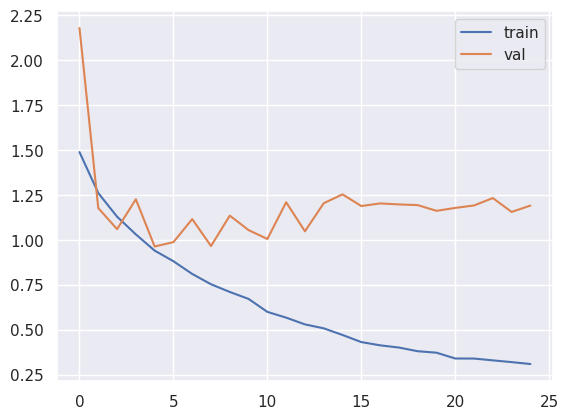

In [9]:
_, train_acc = cnn_model.evaluate(cnn_training, verbose=1)
_, val_acc = cnn_model.evaluate(cnn_val, verbose=1)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))


2022-10-28 10:53:28.718690: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42614784 exceeds 10% of free system memory.
2022-10-28 10:53:28.737278: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42614784 exceeds 10% of free system memory.
2022-10-28 10:53:28.744596: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42614784 exceeds 10% of free system memory.
2022-10-28 10:53:29.174660: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18939904 exceeds 10% of free system memory.
2022-10-28 10:53:29.182460: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18939904 exceeds 10% of free system memory.


Epoch 1/200
391/391 [==============================] - ETA: 0s - loss: 1.4890 - accuracy: 0.3352
Epoch 1: val_accuracy improved from -inf to 0.08092, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 189s 477ms/step - loss: 1.4890 - accuracy: 0.3352 - val_loss: 2.1797 - val_accuracy: 0.0809 - lr: 0.0010
Epoch 2/200
391/391 [==============================] - ETA: 0s - loss: 1.2610 - accuracy: 0.4648
Epoch 2: val_accuracy improved from 0.08092 to 0.46243, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 72s 184ms/step - loss: 1.2610 - accuracy: 0.4648 - val_loss: 1.1775 - val_accuracy: 0.4624 - lr: 0.0010
Epoch 3/200
391/391 [==============================] - ETA: 0s - loss: 1.1295 - accuracy: 0.5344
Epoch 3: val_accuracy improved from 0.46243 to 0.52023, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 72s 185ms/step - loss: 1.1295 - accuracy: 0.5344 - val_loss: 1.0602 - val_accuracy: 0.5202 - lr: 0.0010
Epoch 4/200
391/391 [==============================] - ETA: 0s - loss: 1.0309 - accuracy: 0.5859
Epoch 4: val_accuracy did not improve from 0.52023
391/391 [==============================] - 69s 176ms/step - loss: 1.0309 - accuracy: 0.5859 - val_loss: 1.2265 - val_accuracy: 0.4335 - lr: 0.0010
Epoch 5/200
391/391 [==============================] - ETA: 0s - loss: 0.9407 - accuracy: 0.6302
Epoch 5: val_accuracy improved from 0.52023 to 0.57225, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 72s 184ms/step - loss: 0.9407 - accuracy: 0.6302 - val_loss: 0.9635 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 6/200
391/391 [==============================] - ETA: 0s - loss: 0.8815 - accuracy: 0.6535
Epoch 6: val_accuracy did not improve from 0.57225
391/391 [==============================] - 69s 175ms/step - loss: 0.8815 - accuracy: 0.6535 - val_loss: 0.9879 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 7/200
391/391 [==============================] - ETA: 0s - loss: 0.8108 - accuracy: 0.6848
Epoch 7: val_accuracy did not improve from 0.57225
391/391 [==============================] - 68s 175ms/step - loss: 0.8108 - accuracy: 0.6848 - val_loss: 1.1160 - val_accuracy: 0.5202 - lr: 0.0010
Epoch 8/200
391/391 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.7107
Epoch 8: val_accuracy did not improve from 0.57225
391/391 [==============================] - 69s 175ms/step - loss: 0.7533 - accuracy: 0.7107 - val_loss: 0.9659 - va

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 [==============================] - 72s 185ms/step - loss: 0.6717 - accuracy: 0.7444 - val_loss: 1.0549 - val_accuracy: 0.6243 - lr: 0.0010
Epoch 11/200
391/391 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.7764
Epoch 11: val_accuracy did not improve from 0.62428
391/391 [==============================] - 69s 175ms/step - loss: 0.5996 - accuracy: 0.7764 - val_loss: 1.0054 - val_accuracy: 0.5954 - lr: 5.0000e-04
Epoch 12/200
391/391 [==============================] - ETA: 0s - loss: 0.5675 - accuracy: 0.7904
Epoch 12: val_accuracy did not improve from 0.62428
391/391 [==============================] - 69s 176ms/step - loss: 0.5675 - accuracy: 0.7904 - val_loss: 1.2098 - val_accuracy: 0.5376 - lr: 5.0000e-04
Epoch 13/200
391/391 [==============================] - ETA: 0s - loss: 0.5300 - accuracy: 0.8082
Epoch 13: val_accuracy did not improve from 0.62428
391/391 [==============

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 73s 186ms/step - loss: 0.4011 - accuracy: 0.8610 - val_loss: 1.1978 - val_accuracy: 0.6301 - lr: 2.5000e-04
Epoch 19/200
391/391 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.8654
Epoch 19: val_accuracy did not improve from 0.63006
391/391 [==============================] - 69s 176ms/step - loss: 0.3806 - accuracy: 0.8654 - val_loss: 1.1939 - val_accuracy: 0.6069 - lr: 2.5000e-04
Epoch 20/200
391/391 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8697
Epoch 20: val_accuracy did not improve from 0.63006

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
391/391 [==============================] - 69s 176ms/step - loss: 0.3724 - accuracy: 0.8697 - val_loss: 1.1621 - val_accuracy: 0.5838 - lr: 2.5000e-04
Epoch 21/200
391/391 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8821
Epoch 21: val_accuracy did not improve from 0.63006
391/391 [==========

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 73s 185ms/step - loss: 0.3397 - accuracy: 0.8852 - val_loss: 1.1920 - val_accuracy: 0.6358 - lr: 1.2500e-04
Epoch 23/200
391/391 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8892
Epoch 23: val_accuracy did not improve from 0.63584
391/391 [==============================] - 69s 176ms/step - loss: 0.3297 - accuracy: 0.8892 - val_loss: 1.2331 - val_accuracy: 0.6127 - lr: 1.2500e-04
Epoch 24/200
391/391 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.8899
Epoch 24: val_accuracy did not improve from 0.63584
391/391 [==============================] - 69s 176ms/step - loss: 0.3200 - accuracy: 0.8899 - val_loss: 1.1560 - val_accuracy: 0.6243 - lr: 1.2500e-04
Epoch 25/200
391/391 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.8944
Epoch 25: val_accuracy improved from 0.63584 to 0.64162, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets



Epoch 25: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 5.
391/391 [==============================] - 72s 185ms/step - loss: 0.3094 - accuracy: 0.8944 - val_loss: 1.1912 - val_accuracy: 0.6416 - lr: 1.2500e-04
Epoch 25: early stopping
